In [1]:
# path operations
from glob import glob
import os
from pathlib import Path

# data format and storage
from collections import namedtuple
import pickle

# numerical tools
import numpy as np
import scipy.stats
import pandas as pd

# plotting tools
from matplotlib import pyplot as plt
# %matplotlib notebook

# interactive notebook features
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact

# meg analysis
import mne

In [2]:
sub_params = namedtuple('sub_params',
                        ['pid', 'slopes', 'age', 'gender',
                         'intercepts', 'rsquared'])

In [10]:
camcanroot = Path('/Volumes') / 'Seagate Expansion Drive' /'camcan'
# camcanroot = Path('D:') / 'camcan'
# camcanroot = Path('/data') / 'group' / 'FANS' / 'camcan-meg' / 'camcan165' / 'camcan165'
camcanroot = Path('/Users') / 'jan' / 'Documents' / 'eeg-data' / 'camcan'
# specific paths
megdataroot = camcanroot / 'cc700' / 'mri' / 'pipeline' / 'release004' / 'BIDSsep' / 'megraw'
pickleroot = Path('.') / 'pickles'


In [11]:
subject_details = pd.DataFrame.from_csv(
    camcanroot / 'cc700-scored' / 'participant_data.csv')
print(f'Found subject information on {len([pid for pid in ids if pid in subject_details.index])} subjects.')

Found subject information on 168 subjects.


In [4]:
# load the task data from pickles
taskpickles = list(pickleroot.glob(pattern='*task.pickle'))
print(f'{len(taskpickles)} files found.')

ids = [str(name)[8:16] for name in taskpickles]

tuplist = [pickle.load(open(f, 'rb')) for f in taskpickles]
tuplist = list(zip(*tuplist))

psds = list(tuplist[0])
all_parameters = list(tuplist[1])

168 files found.


In [15]:
subject_details.loc[ids[0], 'age']

24

In [5]:
# also load the rest data from the pickles

restpickles = [f for f in list(pickleroot.glob(pattern='*.pickle'))
               if 'task' not in str(f) and str(f)[8:16] in ids]

# ensure they are in the same order
# if any pair of strings get printed here,
# figure out how to fix it
for r, t in zip(restpickles, taskpickles):
    if str(r)[8:16] != str(t)[8:16]:
        print(str(r)[8:16])
        print(str(t)[8:16])

tuplist = [pickle.load(open(f, 'rb')) for f in restpickles]
tuplist = list(zip(*tuplist))

restpsds = list(tuplist[0])
restall_parameters = list(tuplist[1])

In [16]:
all_parameters = []

freqs = np.linspace(2, 24, num=psds[0].shape[-1])

for subject, psd in enumerate(psds):
    
    # Do the linear regression
    findices = (freqs < 7) | (freqs > 14)
    linfits = [scipy.stats.linregress(freqs[findices], np.log10(psd.T[findices, grad]))
               for grad in range(psd.shape[0])]
    
    all_parameters.append(
        sub_params(pid=ids[subject],
                   slopes=np.array([l.slope for l in linfits]),
                   intercepts=np.array([l.intercept for l in linfits]),
                   rsquared=np.array([l.rvalue**2 for l in linfits]),
                   age=subject_details.loc[ids[subject], 'age'],
                   gender=1)
    )
    
restall_parameters = []

for subject, psd in enumerate(restpsds):
    
    # Do the linear regression
    findices = (freqs < 7) | (freqs > 14)
    linfits = [scipy.stats.linregress(freqs[findices], np.log10(psd.T[findices, grad]))
               for grad in range(psd.shape[0])]
    
    restall_parameters.append(
        sub_params(pid=ids[subject],
                   slopes=np.array([l.slope for l in linfits]),
                   intercepts=np.array([l.intercept for l in linfits]),
                   rsquared=np.array([l.rvalue**2 for l in linfits]),
                   age=subject_details.loc[ids[subject], 'age'],
                   gender=1)
    )

In [17]:
bad_elecs = []

for pid in range(len(psds)):
    bads = np.zeros_like(all_parameters[pid].rsquared, dtype='bool')
    bads = bads | (all_parameters[pid].slopes > 0)
    bads = bads | (all_parameters[pid].intercepts >
                   all_parameters[pid].intercepts.mean() +
                   2 * all_parameters[pid].intercepts.std())
    bads = bads | (all_parameters[pid].intercepts <
                   all_parameters[pid].intercepts.mean() -
                   2 * all_parameters[pid].intercepts.std())
    bad_elecs.append(bads)

    
restbad_elecs = []
for pid in range(len(psds)):
    bads = np.zeros_like(all_parameters[pid].rsquared, dtype='bool')
    bads = bads | (restall_parameters[pid].slopes > 0)
    bads = bads | (restall_parameters[pid].intercepts >
                   restall_parameters[pid].intercepts.mean() +
                   2 * restall_parameters[pid].intercepts.std())
    bads = bads | (restall_parameters[pid].intercepts <
                   restall_parameters[pid].intercepts.mean() -
                   2 * restall_parameters[pid].intercepts.std())
    restbad_elecs.append(bads)



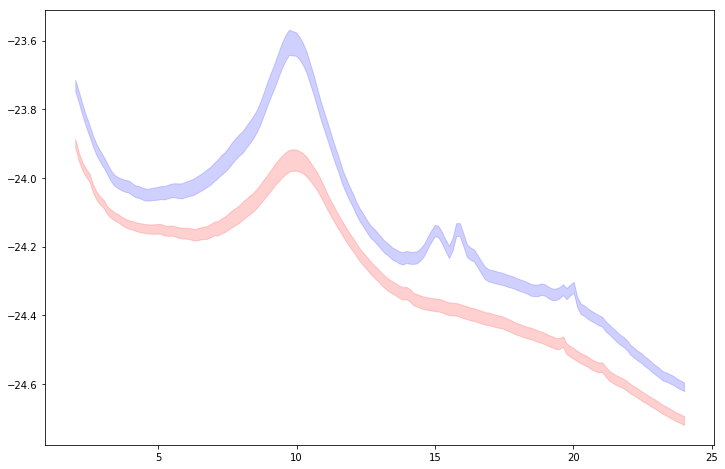

In [18]:
pltdatas = [np.log10(np.stack([p[~e, :].mean(axis=0)
                             for i, (p, e) in enumerate(zip(ps, es))],
                             axis=-1))
            for ps, es in [(psds, bad_elecs), (restpsds, restbad_elecs)]]

x = freqs

plt.figure(figsize=(12, 8))
for pltdata, color in zip(pltdatas, [[1, 0.4, 0.4], [0.4, 0.4, 1]]):
    plt.fill_between(
            x, np.mean(pltdata, axis=-1)-scipy.stats.sem(pltdata, axis=-1),
            np.mean(pltdata, axis=-1)+scipy.stats.sem(pltdata, axis=-1),
            color=color+[0.3]
        )
# plt.plot(x, pltdata, color=(0.5, 0.5, 1, 0.5))
# plt.plot(x, np.mean(pltdata, axis=-1), color='orange')
plt.show()

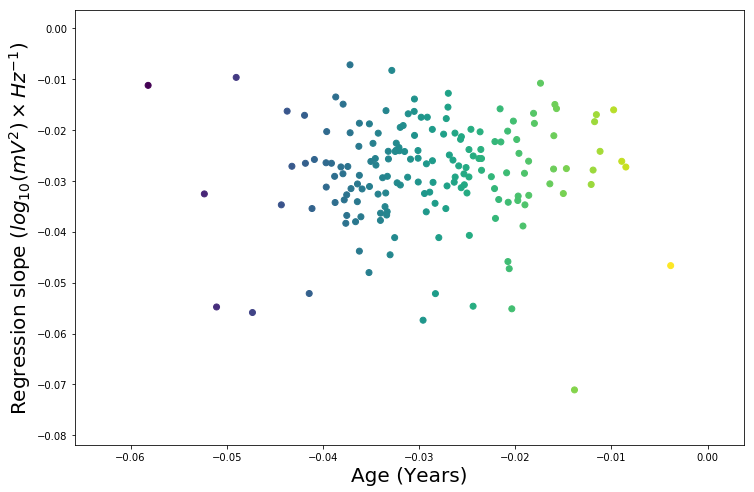

(0.014599586456087226, 0.8510103443195508)


In [21]:
x = [np.mean(p.slopes[~e]) for p, e in zip(all_parameters, bad_elecs)]
y = [np.mean(p.slopes[~e]) for p, e in zip(restall_parameters, restbad_elecs)]

plt.figure(figsize=(12, 8))
plt.scatter(x, y, c=x)
plt.xlabel(r'Age (Years)', fontsize=20)
plt.ylabel(r'Regression slope ($log_{10}(mV^2) \times Hz^{-1}$)', fontsize=20)
plt.show()

print(scipy.stats.pearsonr(x, y))

In [22]:
ages = np.array([p.age for p in all_parameters])
young = ages < np.percentile(ages, 25)
old = ages > np.percentile(ages, 75)

In [25]:
pltdata.shape

(172, 42)

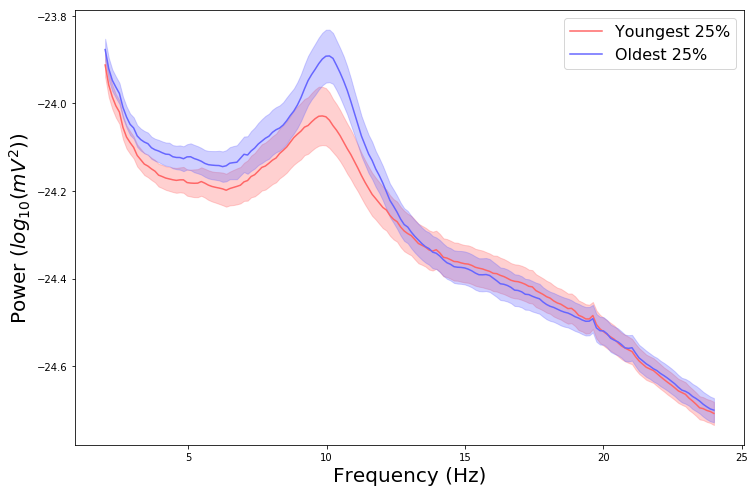

In [29]:
plt.figure(figsize=(12, 8))

legendentries = []
for group, color, label in [(young, [1, 0.4, 0.4], 'Youngest 25%'), (old, [0.4, 0.4, 1], 'Oldest 25%')]:
    pltdata = np.log10(np.stack([p[~bad_elecs[i], :].mean(axis=0)
                                 for i, p in enumerate(psds)
                                 if group[i]],
                                axis=-1))
    plt.fill_between(
        freqs,
        np.mean(pltdata, axis=-1)-scipy.stats.sem(pltdata, axis=-1),
        np.mean(pltdata, axis=-1)+scipy.stats.sem(pltdata, axis=-1),
        color=color + [0.3]
    )
    legendentries.append(plt.plot(freqs, np.mean(pltdata, axis=-1), color=color, label=label))

plt.ylabel('Power ($log_{10}(mV^2)$)', fontsize=20)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.legend(fontsize=16)
plt.show()

In [35]:
def individual_spectrum(subjectno):
    dat = psds[subjectno]
    plt.figure(figsize=(12, 6))
    # plot individual lines, faint
    plt.plot(freqs, np.log10(dat.T), color=(0.5, 0.5, 1.0, 0.1))
    plt.plot(freqs, np.log10(dat).mean(axis=0), color=(1, 0.3, 0.3))
    plt.show()

interact(individual_spectrum, subjectno=(0, len(psds)-1))

<function __main__.individual_spectrum>

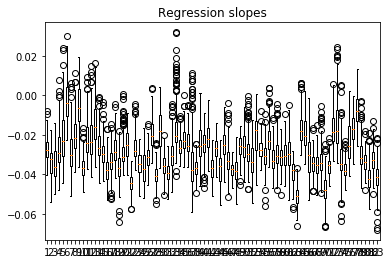

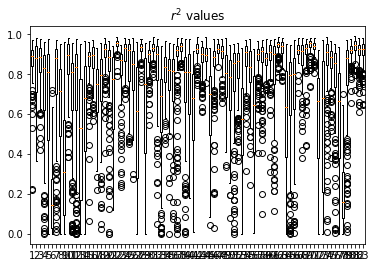

In [36]:
y = np.array([p.slopes for p in all_parameters])

plt.figure()
plt.boxplot(y.T)
plt.title('Regression slopes')
plt.show()

y = np.array([p.rsquared for p in all_parameters])

plt.figure()
plt.boxplot(y.T)
plt.title('$r^2$ values')
plt.show()


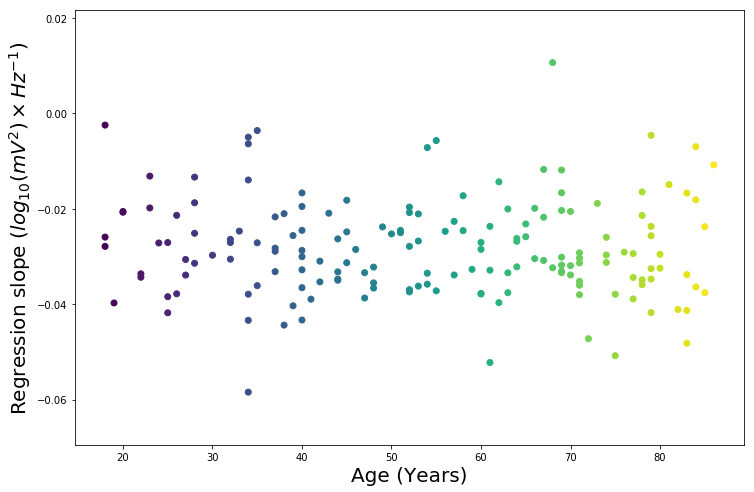

(-0.041968094182539654, 0.58909674112250143)


In [31]:
x = [p.age for p in all_parameters]
y = [np.mean(p.slopes) for i, p in enumerate(all_parameters)]

plt.figure(figsize=(12, 8))
plt.scatter(x, y, c=x)
plt.xlabel(r'Age (Years)', fontsize=20)
plt.ylabel(r'Regression slope ($log_{10}(mV^2) \times Hz^{-1}$)', fontsize=20)
plt.show()

print(scipy.stats.pearsonr(x, y))


In [38]:
# Load the short-term memory data
stm = pd.read_csv(
    camcanroot / 'cc700-scored' / 'VSTMcolour' / 'release001' / 'summary' / 'VSTMcolour_summary.txt',
    sep='\t', skiprows=8, index_col=0
)

FileNotFoundError: File b'/Volumes/Seagate Expansion Drive/camcan/cc700-scored/VSTMcolour/release001/summary/VSTMcolour_summary.txt' does not exist

In [ ]:
ages = [p.age for p in all_parameters if p.pid in stm.index]
slopes = [np.mean(p.slopes[~bad_elecs[i]]) for i, p in enumerate(all_parameters) if p.pid in stm.index]

x = slopes
y = [float(stm.loc[p.pid, 'Prcsn_ss3'])
                 for p in all_parameters
                 if p.pid in stm.index]

print(scipy.stats.pearsonr(x, y))

plt.figure(figsize=(12, 8))
plt.scatter(x, y)
plt.ylabel(r'Short term memory performance', fontsize=20)
plt.xlabel(r'Regression slope ($log_{10}(mV^2) \times Hz^{-1}$)', fontsize=20)
plt.show()